# 1.Prepare for dataset 

## 1.1download data from yahoo 
seperate the dataframes into several dataframes by closing price and volume

In [ ]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

tickers_list = pd.read_csv('Yahoo_Ticker_Symbols.csv')

tickers_list.drop(columns=['Category Name'],axis=1,inplace=True)

tickers = list(tickers_list.Ticker)

len(tickers)

start_time = datetime.strptime('Jan 1 2000 ', '%b %d %Y ')
start_time

for i in range(0,21):
    start = i * 5000
    end = (i+1)*5000
    Total_data_1 = pdr.get_data_yahoo(tickers=tickers[start:end],start=start_time,end=datetime.now())
    closing_price = Total_data_1['Close']
    volume = Total_data_1['Volume']
    closing_price.to_csv('closing_part'+str(i)+'.csv')
    volume.to_csv('volume_part'+str(i)+'.csv')
    print('finished '+str(i)+'loop')

In [48]:
tickers_list = pd.read_csv('Yahoo_Ticker_Symbols.csv')
len(tickers_list)

106328

## 1.2 input data as dataframe through pandas from csv files
transfer dataframe index from str to datetime to filter data on Saturday and then output as pickle file to easy input in the future analysis.

In [ ]:
import glob
import pandas as pd 
path ='data' # use your path
allFiles = glob.glob(path + "/*.csv")

clo_price_data = []
vol_data = []
for file in allFiles:
    if file.startswith('data/closing'):
        data = pd.read_csv(file).set_index('Date')
        clo_price_data.append(data)
        print('Successful import closing price file '+file)
#     else:
#         data = pd.read_csv(file).set_index('Date')
#         vol_data.append(data)
#         print('Successful import volume  file'+file)
data_clo = pd.concat(clo_price_data, axis = 1, ignore_index = False,sort=False)
data_clo.index = pd.to_datetime(data_clo.index)
# data_clo.sort_index(inplace=True)
# data_clo = data_clo.iloc[2:-1,:]

clo_price_data  = []
data_clo.index = pd.to_datetime(data_clo.index)

data_clo[data_clo.index.weekday!=6].to_pickle('data/closing_price.pkl')

## 1.3 data preprocessing 

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats as stats
from sklearn.covariance import LedoitWolf
import scipy.optimize as sco

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
clo_data = pd.read_pickle('data/closing_price.pkl')

In [3]:
clo_data.index = pd.to_datetime(clo_data.index)
clo_data.sort_index(inplace=True)  ## transfet index from str to datetime and then sort by datetime

In [4]:
clo_data.head()

,000590.KS,001040.KS,001045.KS,0038.HK,0042.HK,0107.HK,011150.KS,011155.KS,016.BE,016.SG,...,ZGL.AX,ZION,ZIONW,ZIONZ,ZIXI,ZMD.V,ZNH,ZURVY,ZZ-B.ST,ZZZ.TO
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.42703,55.5000,NaN,NaN,37.1875,NaN,7.125000,NaN,NaN,NaN
2000-01-04,10732.700195,20294.300781,57695.000000,1.10,0.44,0.55,990.0,NaN,NaN,NaN,...,0.40395,52.8125,NaN,NaN,36.5000,NaN,7.208333,NaN,NaN,NaN
2000-01-05,9920.519531,17938.699219,51069.699219,1.09,0.40,0.53,1135.0,NaN,NaN,NaN,...,0.40395,52.7500,NaN,NaN,37.2812,NaN,7.000000,NaN,NaN,NaN
2000-01-06,10210.599609,16126.700195,47895.101563,1.06,0.37,0.51,1195.0,NaN,NaN,NaN,...,0.40395,53.5000,NaN,NaN,35.2500,NaN,7.166667,NaN,NaN,NaN
2000-01-07,9427.389648,16126.700195,46928.898438,1.13,0.41,0.54,1030.0,NaN,NaN,NaN,...,NaN,53.6250,NaN,NaN,38.0000,NaN,7.250000,NaN,NaN,NaN


In [5]:
numNAs = (clo_data.isna().sum()/len(clo_data)).copy()

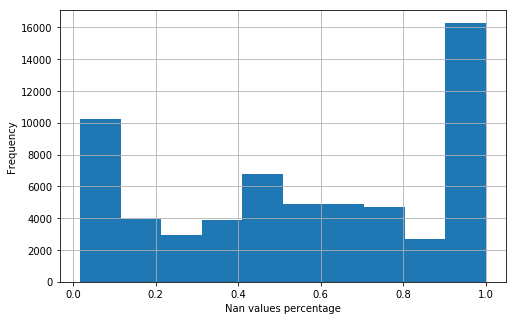

In [6]:

fig,ax = plt.subplots(figsize=(8,5))
numNAs.hist()
ax.set_xlabel('Nan values percentage')
ax.set_ylabel('Frequency')
fig.savefig('figure/Nan_value_distribution.jpg')

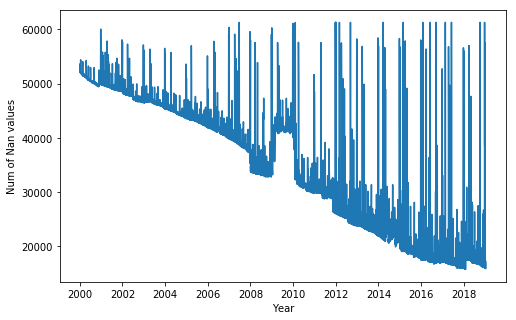

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
clearn_numNAs = clo_data.isna().sum(axis=1)
plt.plot(clearn_numNAs)
ax.set_xlabel('Year')
ax.set_ylabel('Num of Nan values')
fig.savefig('figure/Nan_value_distribution2.jpg')

### select stocks which have at most 3% data missing 

In [6]:
stock_list =(numNAs<=0.025).copy()
stock_list = stock_list[stock_list==True]
cleaned_clo_data = clo_data[list(stock_list.index)]
# we select stock with nan value percentage less then 3%
# large threshold will lead to a not precision result and too low may cause too less stocks

cleaned_clo_data

,CIN.L,CIR.MI,CKN.L,CLE.MI,CLI.L,CRI.PA,CSP.MI,CSRT.L,CTAC.AS,CTRG.PA,...,RBS.L,REC.BR,RMS.PA,SAB.MC,SAN.MC,SIP.BR,SIPH.PA,SOLV.BR,TESB.BR,UCB.BR
2000-01-03,2384.379883,2.425,93.5,41.136902,13.55,18.600000,5.050,504.250000,9.950000,4.5450,...,3141.439941,NaN,49.033298,2.78284,10.27760,NaN,NaN,NaN,NaN,NaN
2000-01-04,2452.500000,2.335,93.5,39.568501,13.55,18.766701,4.860,504.250000,9.500000,4.4875,...,3055.610107,7.96569,46.033298,2.78284,10.03370,9.075850,NaN,76.079300,45.554298,41.000000
2000-01-05,2222.399902,2.185,87.5,37.306000,13.45,19.000000,4.740,508.623993,9.200000,4.3300,...,3084.219971,7.96569,42.666698,2.78284,9.78990,9.114850,NaN,70.844902,45.084599,39.779999
2000-01-06,2222.399902,2.150,87.5,33.835098,13.25,19.333300,4.700,537.924988,9.200000,4.4875,...,3089.939941,7.96569,41.666698,2.78284,9.78990,9.163590,NaN,72.198601,45.695202,38.650002
2000-01-07,2222.399902,2.200,87.5,37.203201,13.25,19.366699,4.750,537.924988,9.500000,4.3325,...,3109.969971,7.98203,44.333302,2.78284,10.22340,9.261070,NaN,73.101097,49.593102,39.849998
2000-01-10,2251.639893,2.200,87.5,39.979900,13.25,19.533300,4.780,537.924988,9.600000,4.4875,...,3135.719971,8.16993,45.833302,2.76779,10.13310,9.261070,NaN,73.552299,51.612499,42.200001
2000-01-11,2462.229980,2.380,87.5,42.293900,13.25,19.333300,4.730,511.684998,9.250000,4.3750,...,3098.530029,8.16993,44.266701,2.76779,9.78990,9.261070,NaN,73.552299,51.612499,42.200001
2000-01-12,2563.550049,2.580,87.5,41.651100,13.25,19.533300,4.720,511.684998,9.150000,4.3750,...,3027.000000,8.57843,44.966702,2.76779,9.69959,9.066100,NaN,72.649803,47.104099,40.900002
2000-01-13,2992.439941,2.690,87.5,40.776901,13.25,19.033300,4.620,506.000000,9.200000,4.2300,...,3009.830078,8.33333,46.966702,2.76779,9.61830,9.163590,3.389000,73.101097,48.137199,40.430000
2000-01-14,4776.200195,2.715,87.5,40.751202,13.40,19.266701,4.620,498.565002,9.250000,4.2325,...,2955.469971,8.16993,51.633301,2.76779,9.87118,9.066100,3.389000,73.101097,48.043301,40.000000


### distribution of stocks on exchange

<BarContainer object of 10 artists>

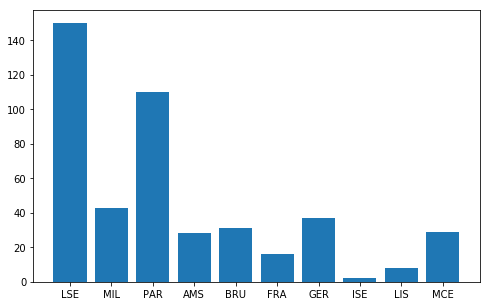

In [9]:
tickers_list = pd.read_csv('Yahoo_Ticker_Symbols.csv')

Exchange_list = tickers_list.Exchange.unique()

Ticker_df = tickers_list.set_index('Ticker')

Exchange_dict = {}
for name in cleaned_clo_data.columns:
    exchange = Ticker_df.loc[name].Exchange
    if exchange not in Exchange_dict.keys():
        Exchange_dict[exchange] = [name]
    else:
        Exchange_dict[exchange].append(name)

xdata = list(Exchange_dict.keys())
ydata = [len(Exchange_dict[key]) for key in xdata]

fig,ax = plt.subplots(figsize=(8,5))
plt.bar(xdata,ydata)

### fill nan value by ??? method  and drop ticker with nan at the begining 

In [8]:
price_data = cleaned_clo_data.fillna(method='ffill')
price_data = price_data.dropna(axis=1)

price_data

,CIN.L,CIR.MI,CKN.L,CLE.MI,CLI.L,CRI.PA,CSP.MI,CSRT.L,CTAC.AS,CTRG.PA,...,DBK.DE,EN.PA,FSJ.L,G1A.DE,LLOY.L,MGAM.L,RBS.L,RMS.PA,SAB.MC,SAN.MC
2000-01-03,2384.379883,2.425,93.5,41.136902,13.55,18.600000,5.050,504.250000,9.950000,4.5450,...,65.045197,63.599998,74.0,20.100000,503.139008,280.765991,3141.439941,49.033298,2.78284,10.27760
2000-01-04,2452.500000,2.335,93.5,39.568501,13.55,18.766701,4.860,504.250000,9.500000,4.4875,...,61.775101,60.450001,74.0,19.520000,471.631989,279.316010,3055.610107,46.033298,2.78284,10.03370
2000-01-05,2222.399902,2.185,87.5,37.306000,13.45,19.000000,4.740,508.623993,9.200000,4.3300,...,60.974998,59.299999,74.0,19.700001,470.983002,273.516998,3084.219971,42.666698,2.78284,9.78990
2000-01-06,2222.399902,2.150,87.5,33.835098,13.25,19.333300,4.700,537.924988,9.200000,4.4875,...,64.082001,57.000000,74.0,19.559999,455.391998,294.296997,3089.939941,41.666698,2.78284,9.78990
2000-01-07,2222.399902,2.200,87.5,37.203201,13.25,19.366699,4.750,537.924988,9.500000,4.3325,...,66.023903,56.200001,76.0,21.400000,439.476013,300.096008,3109.969971,44.333302,2.78284,10.22340
2000-01-10,2251.639893,2.200,87.5,39.979900,13.25,19.533300,4.780,537.924988,9.600000,4.4875,...,64.322800,60.150002,77.5,21.700001,451.819000,294.296997,3135.719971,45.833302,2.76779,10.13310
2000-01-11,2462.229980,2.380,87.5,42.293900,13.25,19.333300,4.730,511.684998,9.250000,4.3750,...,64.548103,62.599998,76.5,22.000000,431.355011,278.833008,3098.530029,44.266701,2.76779,9.78990
2000-01-12,2563.550049,2.580,87.5,41.651100,13.25,19.533300,4.720,511.684998,9.150000,4.3750,...,62.606201,60.880001,75.0,22.000000,434.602997,272.066986,3027.000000,44.966702,2.76779,9.69959
2000-01-13,2992.439941,2.690,87.5,40.776901,13.25,19.033300,4.620,506.000000,9.200000,4.2300,...,64.897598,63.500000,74.0,22.000000,434.928009,258.536987,3009.830078,46.966702,2.76779,9.61830
2000-01-14,4776.200195,2.715,87.5,40.751202,13.40,19.266701,4.620,498.565002,9.250000,4.2325,...,65.324799,64.000000,72.5,21.879999,436.877014,258.053009,2955.469971,51.633301,2.76779,9.87118


## 1.4 Compute price return and then plot one stock price return as example. 

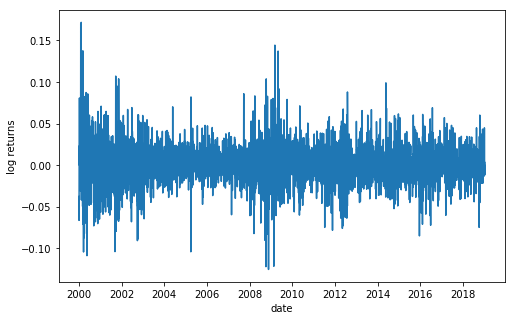

In [9]:
def log_return(row):
    r = np.log(row).diff()
    return r 

log_return = np.log(price_data).diff()

fig,ax = plt.subplots(figsize=(8,5))
plt.plot(log_return.iloc[:,1]) # plot the stock called 'CIR.MI'
ax.set_xlabel('date')
ax.set_ylabel('log returns')
fig.savefig('figure/log_returns_for_CIR_MI.jpg')

In [10]:
log_return

,CIN.L,CIR.MI,CKN.L,CLE.MI,CLI.L,CRI.PA,CSP.MI,CSRT.L,CTAC.AS,CTRG.PA,...,DBK.DE,EN.PA,FSJ.L,G1A.DE,LLOY.L,MGAM.L,RBS.L,RMS.PA,SAB.MC,SAN.MC
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.028169,-0.037820,0.000000,-0.038872,0.000000,0.008922,-0.038350,0.000000,-0.046281,-0.012732,...,-0.051582,-0.050797,0.000000,-0.029280,-0.064667,-0.005178,-0.027702,-0.063135,0.000000,-0.024017
2000-01-05,-0.098520,-0.066396,-0.066323,-0.058879,-0.007407,0.012355,-0.025001,0.008637,-0.032088,-0.035728,...,-0.013036,-0.019207,0.000000,0.009179,-0.001377,-0.020980,0.009319,-0.075946,0.000000,-0.024598
2000-01-06,0.000000,-0.016148,0.000000,-0.097656,-0.014982,0.017390,-0.008475,0.056010,0.000000,0.035728,...,0.049700,-0.039558,0.000000,-0.007132,-0.033663,0.073226,0.001853,-0.023717,0.000000,0.000000
2000-01-07,0.000000,0.022990,0.000000,0.094896,0.000000,0.001726,0.010582,0.000000,0.032088,-0.035151,...,0.029853,-0.014134,0.026668,0.089904,-0.035575,0.019513,0.006461,0.062034,0.000000,0.043328
2000-01-10,0.013071,0.000000,0.000000,0.071982,0.000000,0.008566,0.006296,0.000000,0.010471,0.035151,...,-0.026103,0.067925,0.019545,0.013921,0.027699,-0.019513,0.008246,0.033275,-0.005423,-0.008872
2000-01-11,0.089409,0.078643,0.000000,0.056266,0.000000,-0.010292,-0.010515,-0.050010,-0.037140,-0.025389,...,0.003497,0.039924,-0.012987,0.013730,-0.046350,-0.053976,-0.011931,-0.034778,0.000000,-0.034456
2000-01-12,0.040326,0.080689,0.000000,-0.015315,0.000000,0.010292,-0.002116,0.000000,-0.010870,0.000000,...,-0.030546,-0.027861,-0.019803,0.000000,0.007502,-0.024565,-0.023356,0.015690,0.000000,-0.009268
2000-01-13,0.154696,0.041752,0.000000,-0.021212,0.000000,-0.025931,-0.021414,-0.011173,0.005450,-0.033705,...,0.035946,0.042135,-0.013423,0.000000,0.000748,-0.051010,-0.005688,0.043517,0.000000,-0.008416
2000-01-14,0.467556,0.009251,0.000000,-0.000630,0.011257,0.012188,0.000000,-0.014803,0.005420,0.000591,...,0.006561,0.007843,-0.020479,-0.005470,0.004471,-0.001874,-0.018226,0.094728,0.000000,0.025952


 ### The autocorrelation function of returns
 compute the autocorrelation of 'CIR.MI' ticker

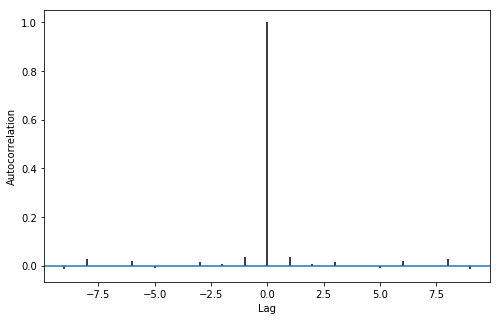

In [11]:
data_acc = np.array(list(log_return.iloc[1:,1]))
fig,ax = plt.subplots(figsize=(8,5))
plt.acorr(data_acc, maxlags=9)
#plt.title('Autocorrelation of CIR.MI stock log returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
# Display the autocorrelation plot
plt.show()
fig.savefig('figure/autocorrelation')

### plot cdf

In [14]:
data_acc = abs(np.array(log_return.iloc[1:,1]))

xdata = np.arange(0,0.101,0.001)

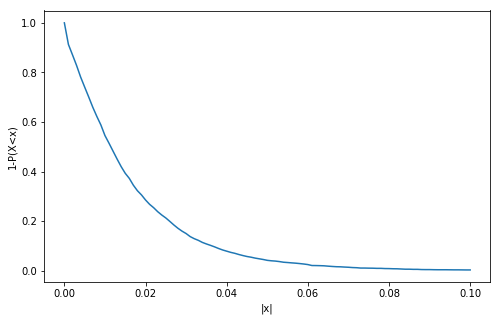

In [15]:
def cdf(data):
    CDF = []
    length = xdata.size
    for i in range(length):
        fre = (data<xdata[i]).sum()
        CDF.append(1-fre/len(data))
    return CDF
fig,ax = plt.subplots(figsize=(8,5))
plt.plot(xdata,cdf(data_acc))
ax.set_xlabel('|x|')
ax.set_ylabel('1-P(X<x)')
fig.savefig('figure/cdf_fig')

# Markowitz  mean-variance portfolio
we separate our data into two parts in order to do out-sample prediction.

def random_portfolio(returns_mean,returns_cov):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = returns_mean
    w = np.random.random(num_stocks)
    w /=np.sum(w)
    C = returns_cov
    mu = np.sum(p*w)
    sigma = np.sqrt(np.dot(w.T,np.dot(C,w)))
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 1:
        return random_portfolio(returns)
    return mu, sigma

def statistics(weights):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    weights = np.array(weights)
    pret = np.sum(returns_mean * weights) # total returns 
    pvol = np.sqrt(np.dot(weights.T, np.dot(returns_cov, weights))) # std 
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [12]:
def corr2cov(corr,std):
    std_diag = np.diag(std)
    cov = np.dot(np.dot(std_diag,corr),std_diag)
    return cov

def compute_cov_metrix(returns,method,threshold=0):
    if method == 'normal':
        corr = np.corrcoef(returns.T)
        std = returns.std()
        return corr2cov(corr,std)
    elif method == 'Shrinkage':
        
        return 0
    elif method =='clipping':
        corr = np.corrcoef(returns.T)
        std = returns.std() 
        u,v = np.linalg.eig(corr)
        N =len(u)
        C_clean = np.zeros((N,N))
        v_m = np.matrix(v.T)
        lambda_M = max(u)
        for i in range(N):
            if u[i] > threshold and u[i] < lambda_M:
                C_clean = C_clean + u[i] * np.dot(v_m[i,].T,v_m[i,])
        return np.array(C_clean)

### we use rolling window method to evaluate optimal portfolio
and window size=2000 > 2 * stocks

In [13]:
class Returns:
    def __init__(self, mean,cov):
        self.mean = mean
        self.cov = cov
        
    def statistics(self,weights):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

        weights = np.array(weights)
        pret = np.sum(self.mean * weights) # total returns 
        pvol = np.sqrt(np.dot(weights.T, np.dot(self.cov, weights))) # std 
        return np.array([pret, pvol, pret / pvol])

    def min_func_sharpe(self,weights):
        return -self.statistics(weights)[2]
    
    def min_func_variance(self,weights):
        return self.statistics(weights)[1]**2

    def min_func_port(self,weights):
        return self.statistics(weights)[1]  

In [14]:
def predict(weights,re):        
    weights = np.array(weights)
    pre_ret = np.sum(re * weights) # total returns 
    return pre_ret

In [15]:
clean_log_return = log_return.iloc[1:,:]
date_length = len(clean_log_return)
num_stocks = len(clean_log_return.columns)
n_portfolios = 25000
bnds = tuple((0, 1) for x in range(num_stocks))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
init = num_stocks * [1. / num_stocks,]
window_length = 2000
time_interval = 10
q = num_stocks*1.0/window_length
lambda_plus = (1 + np.sqrt(q))**2

methods = ['normal','clipping']
a = []
ind = clean_log_return.index
for method in methods:
    strategy = pd.DataFrame(columns=clean_log_return.columns[:num_stocks])
    for time in range(0,date_length-window_length-time_interval,time_interval):
        print('from '+ str(ind[time])+' to'+ str(ind[time+window_length-1]))
        returns = clean_log_return.iloc[time:time+window_length,:num_stocks]
        date = clean_log_return.index[time+window_length]
        returns_mean = returns.mean()*252
        returns_cov =  compute_cov_metrix(returns,method,threshold=lambda_plus)*252
        Re = Returns(returns_mean,returns_cov)
        #means,stds = np.column_stack([random_portfolio(returns_mean,returns_cov) for _ in range(n_portfolios)])
        opts = sco.minimize(Re.min_func_sharpe,init, method='SLSQP',  bounds=bnds, constraints=cons)
        strategy.loc[date,:] = opts['x']
    strategy.to_csv('min_sharpe_Weight_'+method+'.csv')
    a.append(strategy)

b = []
for method in methods:
    strategy = pd.DataFrame(columns=clean_log_return.columns[:num_stocks])
    for time in range(0,date_length-window_length-time_interval,time_interval):
        print('from '+ str(ind[time])+' to'+ str(ind[time+window_length-1]))
        returns = clean_log_return.iloc[time:time+window_length,:num_stocks]
        date = clean_log_return.index[time+window_length]
        returns_mean = returns.mean()*252
        returns_cov =  compute_cov_metrix(returns,method,threshold=lambda_plus)*252
        Re = Returns(returns_mean,returns_cov)
        #means,stds = np.column_stack([random_portfolio(returns_mean,returns_cov) for _ in range(n_portfolios)])
        opts = sco.minimize(Re.min_func_variance,init, method='SLSQP',  bounds=bnds, constraints=cons)
        strategy.loc[date,:] = opts['x']
    strategy.to_csv('min_variance_Weight_'+method+'.csv')
    b.append(strategy)

In [20]:
nor_sharp_weight = pd.read_csv('min_sharpe_Weight_normal.csv',index_col=0)
clip_sharp_weight = pd.read_csv('min_sharpe_Weight_clipping.csv',index_col=0)
nor_var_weight = pd.read_csv('min_variance_Weight_normal.csv',index_col=0)
clip_var_weight = pd.read_csv('min_variance_Weight_clipping.csv',index_col=0)

In [21]:
nor_sharp_weight

,CIN.L,CIR.MI,CKN.L,CLE.MI,CLI.L,CRI.PA,CSP.MI,CSRT.L,CTAC.AS,CTRG.PA,...,DBK.DE,EN.PA,FSJ.L,G1A.DE,LLOY.L,MGAM.L,RBS.L,RMS.PA,SAB.MC,SAN.MC
2007-09-03,1.786328e-14,2.079787e-12,1.444398e-02,1.552064e-11,6.349675e-14,5.965242e-14,2.747037e-12,5.358400e-14,9.114346e-12,7.983860e-14,...,4.162943e-12,4.569604e-12,3.579884e-02,6.305102e-12,2.387234e-12,2.928328e-12,2.280448e-12,1.072342e-14,3.982509e-14,3.626153e-12
2007-09-17,5.659822e-13,6.033151e-13,1.559788e-02,3.313988e-12,3.129622e-12,2.676333e-12,6.186376e-13,3.007854e-12,1.916319e-12,2.849720e-04,...,8.727806e-13,1.012840e-12,3.631886e-02,1.376296e-12,4.296427e-13,3.561397e-13,5.108511e-13,6.921988e-13,1.995760e-12,7.083806e-13
2007-10-01,1.653461e-12,2.452008e-12,1.843165e-02,1.673143e-11,1.711726e-12,1.455631e-12,3.653812e-12,1.984670e-12,8.723351e-12,7.696387e-04,...,4.123914e-12,5.054480e-12,3.391408e-02,6.442399e-12,1.730426e-12,1.332986e-12,2.705648e-12,4.478314e-13,1.095987e-12,3.568906e-12
2007-10-15,3.641210e-13,2.814269e-13,1.961884e-02,1.086923e-12,3.062139e-13,3.672100e-13,3.063560e-13,4.581391e-13,6.455334e-13,1.144095e-03,...,2.334995e-13,3.937537e-13,3.429144e-02,3.742443e-13,5.904102e-14,7.916415e-14,7.753013e-14,1.734929e-13,2.470114e-13,2.148303e-13
2007-10-29,2.654682e-13,3.887642e-13,1.196953e-02,1.692903e-12,3.587251e-12,6.122328e-12,2.998337e-13,6.325446e-12,7.727586e-13,1.856163e-03,...,3.143540e-13,5.198291e-13,3.527258e-02,5.691203e-13,2.085733e-13,1.178971e-13,3.778698e-14,2.734277e-12,4.200183e-12,2.258901e-13
2007-11-12,0.000000e+00,0.000000e+00,1.346203e-02,0.000000e+00,5.161166e-12,9.596741e-12,0.000000e+00,1.133330e-11,0.000000e+00,1.486526e-03,...,0.000000e+00,0.000000e+00,3.772455e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.208331e-12,6.693707e-12,0.000000e+00
2007-11-26,0.000000e+00,1.439614e-12,1.983742e-02,5.012435e-12,0.000000e+00,0.000000e+00,1.411406e-12,0.000000e+00,2.917975e-12,3.457040e-03,...,8.239878e-13,1.535307e-12,3.216718e-02,2.066683e-12,4.738093e-13,4.179176e-13,6.256434e-13,0.000000e+00,0.000000e+00,7.828946e-13
2007-12-10,6.914535e-13,4.929590e-12,2.064454e-02,1.658073e-11,3.816893e-14,8.022653e-14,4.842036e-12,1.023228e-13,1.082322e-11,3.988928e-03,...,4.723844e-12,5.233270e-12,3.298180e-02,7.300762e-12,3.281608e-12,3.777696e-12,3.227997e-12,4.991805e-15,8.028125e-14,3.687712e-12
2007-12-24,1.737138e-13,0.000000e+00,2.231045e-02,0.000000e+00,4.720110e-13,9.921586e-13,0.000000e+00,1.078071e-12,0.000000e+00,1.421824e-03,...,0.000000e+00,0.000000e+00,3.229093e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.736817e-13,9.064164e-13,0.000000e+00
2008-01-07,0.000000e+00,5.010315e-14,2.714849e-02,5.904185e-13,0.000000e+00,0.000000e+00,1.429227e-13,0.000000e+00,3.803135e-13,6.828567e-04,...,8.101994e-14,1.926324e-13,3.001799e-02,2.966555e-13,5.803078e-14,1.598019e-13,1.211527e-13,0.000000e+00,0.000000e+00,8.003591e-14


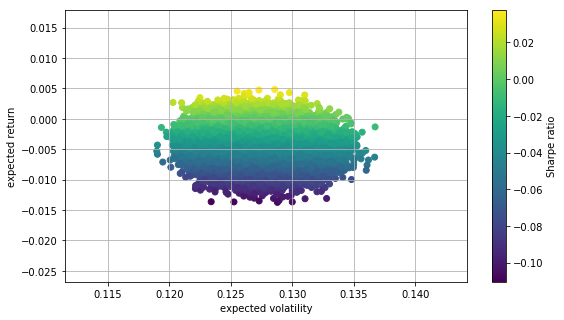

In [28]:
plt.figure(figsize=(9, 5)) 
plt.scatter(stds, means, c=means / stds, marker='o') #画散点图
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

Next, lets evaluate how many of these random portfolios would perform. Towards this goal we are calculating the mean returns as well as the volatility (here we are using standard deviation). You can also see that there is
a filter that only allows to plot portfolios with a standard deviation of < 2 for better illustration.

In [53]:
statistics(opts['x'],returns_mean,returns_cov).round(3)

array([0.121, 0.055, 2.197])

below is used for computing min-variance

In [56]:
target_returns = np.linspace(0.125, 0.25, 20)

target_volatilities = []

for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, num_stocks * [1. / num_stocks,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    target_volatilities.append(res['fun'])

#画散点图
plt.figure(figsize=(9, 5))
#圆点为随机资产组合
plt.scatter(portfolio_volatilities, portfolio_returns,
            c=portfolio_returns / portfolio_volatilities, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns,
            c=target_returns / target_volatilities, marker='x')
#红星为夏普率最大值的资产组合            
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0)
#黄星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

作者：丁立在简书
链接：https://www.jianshu.com/p/0363bc4fdad4
來源：简书
简书著作权归作者所有，任何形式的转载都请联系作者获得授权并注明出处。